# Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task?
What features should be excluded because they leak the target information?
Show visualizations or statistics to support your selection.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

%matplotlib inline

In [2]:
general = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv')

/Users/charlottefeng/anaconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,28,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
research = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv')

/Users/charlottefeng/anaconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (2,5,7,8,9,10,12,15,17,18,19,20,21,22,23,24,25,30,32,35,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,129,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,163,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Subsample the data to facilitate analysis
general_sample = general.sample(frac=0.001, replace=False, random_state=0)
research_sample = research.sample(frac=0.001, replace=False, random_state=0)

## Exclude features that leak target information

In [5]:
common_col = general.columns.intersection(research.columns)
general_common_col = general_sample[common_col]
research_common_col = research_sample[common_col]

In [6]:
len(common_col)

64

- We exclude features that are highly correlated with `y`, including
    - distinct features for each class of `y` (i.e., research/non-research payments)
    - common features with distinct missing patterns
        - Based on the heatmaps, such features are 'Teaching_Hospital_CCN', 'Teaching_Hospital_ID', 'Teaching_Hospital_Name', 'Physician_Primary_Type', 'Physician_Specialty', and 'Physician_License_State_code1'.
- We also exclude features with too many missing values (i.e., >50%) as they are not so informative.

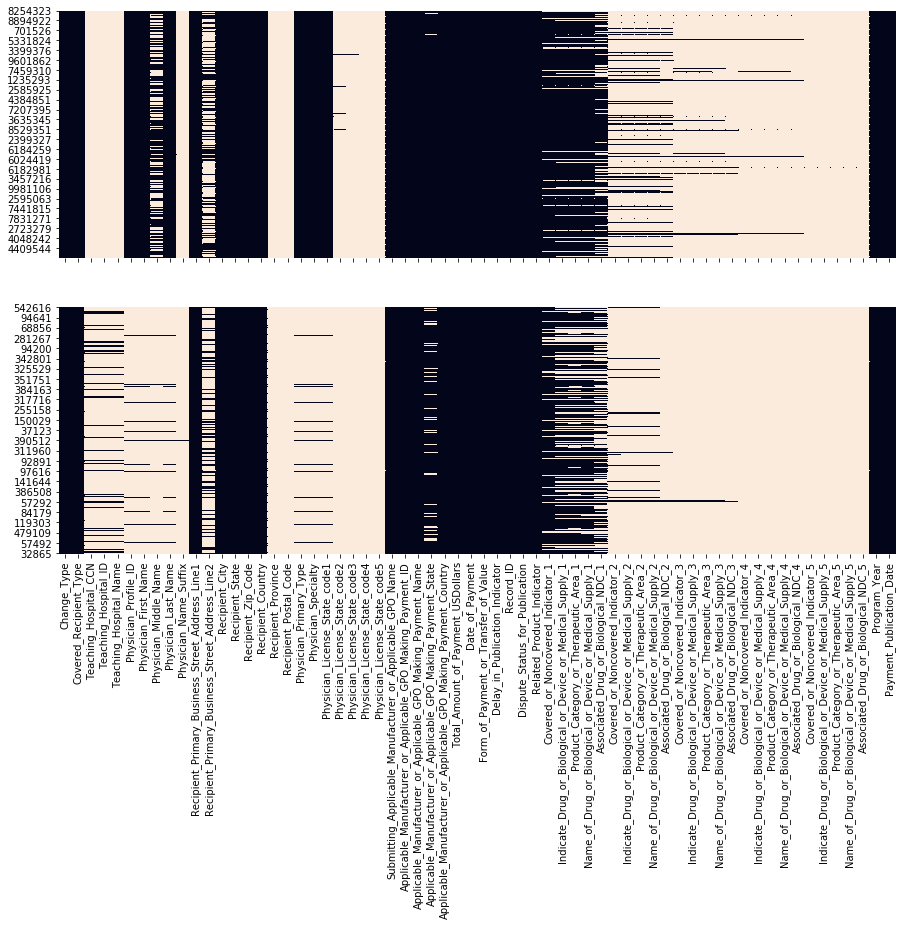

In [7]:
import seaborn as sns
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
_ = sns.heatmap(general_common_col.isnull(), cbar=False, ax=ax[0])
_ = sns.heatmap(research_common_col.isnull(), cbar=False, ax=ax[1])

In [8]:
X = general_common_col.append(research_common_col, sort = False)
exclude_col = ['Teaching_Hospital_CCN', 'Teaching_Hospital_ID', 
               'Teaching_Hospital_Name', 'Physician_Primary_Type', 
               'Physician_Specialty', 'Physician_License_State_code1']
X = X.drop(exclude_col, axis=1)

In [9]:
X = X.dropna(thresh=round(len(X)*0.5), axis=1)

In [10]:
X.shape

(11267, 30)

- We also check the unique categories of the categorical features of general/research payments. For the same categorical feature, if there exists a distinct factor level under either of the two labels, that level will be deterministic in predicting the label it belongs to, thus becoming a strongly influential feature in model prediction. This could be seen by the following model fitting part, where the resulted baseline model is nearly perfect.

In [11]:
mismatch = []
for c in common_col.tolist():
    if (len(general_common_col[c].unique()) <= 10) and (len(research_common_col[c].unique()) <= 10):
        if set(general_common_col[c].unique()) != set(research_common_col[c].unique()):
            print('Mismatched categories for {}\n'.format(c))
            print('where general has {}'.format(general_common_col[c].unique()))
            print('but research has {}\n'.format(research_common_col[c].unique()))
            mismatch.append(c)

Mismatched categories for Covered_Recipient_Type

where general has ['Covered Recipient Physician' 'Covered Recipient Teaching Hospital']
but research has ['Non-covered Recipient Entity' 'Covered Recipient Teaching Hospital'
 'Covered Recipient Physician']

Mismatched categories for Recipient_Country

where general has ['United States' 'United States Minor Outlying Islands']
but research has ['United States']

Mismatched categories for Recipient_Province

where general has [nan 'LA']
but research has [nan]

Mismatched categories for Recipient_Postal_Code

where general has [nan 70115.0]
but research has [nan]

Mismatched categories for Physician_Primary_Type

where general has ['Medical Doctor' 'Doctor of Dentistry' 'Doctor of Osteopathy' nan
 'Doctor of Podiatric Medicine' 'Doctor of Optometry' 'Chiropractor']
but research has [nan 'Medical Doctor' 'Doctor of Optometry']

Mismatched categories for Physician_License_State_code4

where general has [nan 'NC' 'WV' 'MI' 'VA' 'TX' 'OK' 'NY'

In [12]:
mismatch

['Covered_Recipient_Type',
 'Recipient_Country',
 'Recipient_Province',
 'Recipient_Postal_Code',
 'Physician_Primary_Type',
 'Physician_License_State_code4',
 'Physician_License_State_code5',
 'Form_of_Payment_or_Transfer_of_Value',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Covered_or_Noncovered_Indicator_2',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
 'Covered_or_Noncovered_Indicator_3',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3',
 'Covered_or_Noncovered_Indicator_4',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4',
 'Covered_or_Noncovered_Indicator_5',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5',
 'Associated_Drug_or_Biological_NDC_5']

## Exclude features that are irrelevant for the prediction task
- We exclude
    - features for ID, physician or company names
        - 'Physician_Profile_ID', 'Physician_First_Name', 'Physician_Middle_Name', 'Physician_Last_Name',       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',  'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 'Record_ID', 'Associated_Drug_or_Biological_NDC_1'
    - Features that have (almost) consistent values across all records
        - 'Delay_in_Publication_Indicator', 'Program_Year', 'Payment_Publication_Date', 'Dispute_Status_for_Publication'
- To facilitate analysis, we keep only minimum geographical features and exclude
    - 'Recipient_Primary_Business_Street_Address_Line1', 'Recipient_Zip_Code', 'Recipient_City'

In [13]:
X_cat = X.select_dtypes(include = 'object')
for c in X_cat.columns:
    if len(X_cat[c].unique()) <= 10:
        print('Feature: {}'.format(c))
        print('% of category:\n{} \n'.format(X_cat[c].value_counts()/len(X_cat)))

Feature: Change_Type
% of category:
UNCHANGED    0.952250
NEW          0.026981
CHANGED      0.020769
Name: Change_Type, dtype: float64 

Feature: Covered_Recipient_Type
% of category:
Covered Recipient Physician            0.945593
Non-covered Recipient Entity           0.042957
Covered Recipient Teaching Hospital    0.011449
Name: Covered_Recipient_Type, dtype: float64 

Feature: Recipient_Country
% of category:
United States                           0.999911
United States Minor Outlying Islands    0.000089
Name: Recipient_Country, dtype: float64 

Feature: Form_of_Payment_or_Transfer_of_Value
% of category:
In-kind items and services                        0.809355
Cash or cash equivalent                           0.190556
Dividend, profit or other return on investment    0.000089
Name: Form_of_Payment_or_Transfer_of_Value, dtype: float64 

Feature: Delay_in_Publication_Indicator
% of category:
No    1.0
Name: Delay_in_Publication_Indicator, dtype: float64 

Feature: Dispute_Status

In [14]:
irr_col = ['Physician_Profile_ID', 'Physician_First_Name', 
           'Physician_Middle_Name', 'Physician_Last_Name',
           'Recipient_Primary_Business_Street_Address_Line1', 
           'Recipient_Zip_Code', 'Recipient_City',
           'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID', 
           'Record_ID', 'Associated_Drug_or_Biological_NDC_1',
           'Dispute_Status_for_Publication', 'Delay_in_Publication_Indicator', 
           'Program_Year', 'Payment_Publication_Date']
X = X.drop(irr_col, axis=1)

In [15]:
X.shape

(11267, 14)

- At this step we retain only 14 features with their cardinalities shown below:

In [16]:
X.apply(pd.Series.nunique)

Change_Type                                                            3
Covered_Recipient_Type                                                 3
Recipient_State                                                       52
Recipient_Country                                                      2
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State        38
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country      13
Total_Amount_of_Payment_USDollars                                   4634
Date_of_Payment                                                      352
Form_of_Payment_or_Transfer_of_Value                                   3
Related_Product_Indicator                                              2
Covered_or_Noncovered_Indicator_1                                      2
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1              4
Product_Category_or_Therapeutic_Area_1                               572
Name_of_Drug_or_Biological_or_Device_or_Medical_Sup

## Generate `y`
- `y = 1` for research payments and `y = 0` for non-research payments

In [17]:
y = list(map(int, list(np.zeros(general_sample.shape[0])) + 
             list(np.ones(research_sample.shape[0]))))
y = np.array(y).reshape(-1, 1)

# Task 2 Preprocessing and Baseline Model
Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset.

## Preprocessing
- Cleaning up data types
    - To facilitate modeling, we convert `Date_of_Payment` to `Date_of_Payment_in_Quarter`, which is stored as a categorical variable. We then delete the original `Date_of_Payment`.
- Imputing missing values
- OneHotEncoding for categorical variables
- Undersampling for imbalanced dataset

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11267 entries, 8254323 to 410127
Data columns (total 14 columns):
Change_Type                                                         11267 non-null object
Covered_Recipient_Type                                              11267 non-null object
Recipient_State                                                     11266 non-null object
Recipient_Country                                                   11267 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      11099 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    11267 non-null object
Total_Amount_of_Payment_USDollars                                   11267 non-null float64
Date_of_Payment                                                     11267 non-null object
Form_of_Payment_or_Transfer_of_Value                                11267 non-null object
Related_Product_Indicator                                           11267

In [19]:
X['Date_of_Payment'] = pd.to_datetime(X['Date_of_Payment'])
X['Date_of_Payment_in_Quarter'] = pd.PeriodIndex(X.Date_of_Payment, freq='Q')
X['Date_of_Payment_in_Quarter'] = X['Date_of_Payment_in_Quarter'].dt.strftime('%q')

In [20]:
X = X.drop('Date_of_Payment', axis=1)

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11267 entries, 8254323 to 410127
Data columns (total 14 columns):
Change_Type                                                         11267 non-null object
Covered_Recipient_Type                                              11267 non-null object
Recipient_State                                                     11266 non-null object
Recipient_Country                                                   11267 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      11099 non-null object
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    11267 non-null object
Total_Amount_of_Payment_USDollars                                   11267 non-null float64
Form_of_Payment_or_Transfer_of_Value                                11267 non-null object
Related_Product_Indicator                                           11267 non-null object
Covered_or_Noncovered_Indicator_1                                   10666

In [22]:
# For categorical variables, treat NaN as category
X_cat = list(X.select_dtypes(include = 'object'))
fill_values = dict(zip(X_cat, ['missing'] * len(X_cat)))
X = X.fillna(value = fill_values)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

## Initial selection of features
- Intuitively, we only include features that might be important for our model. The baseline model drops
    - 'Recipient_State', 'Recipient_Country', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Form_of_Payment_or_Transfer_of_Value', 'Product_Category_or_Therapeutic_Area_1', 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Date_of_Payment_in_Quarter'

In [24]:
drop_col = ['Recipient_State', 'Recipient_Country', 
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
            'Form_of_Payment_or_Transfer_of_Value',
            'Product_Category_or_Therapeutic_Area_1', 
            'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
            'Date_of_Payment_in_Quarter']
X_train_base = X_train.drop(drop_col, axis=1)
X_train_base.shape

(8450, 6)

In [25]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from dirty_cat import TargetEncoder
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

def fit_model(X_train, y_train, model, advanced_preprocess=False, 
              tuning=False, param_grid=None):
    categorical = X_train.dtypes == object
    # for low-cardinality features, do OneHotEncoding
    low_card_cat = (X_train.dtypes == object) & (X_train.apply(pd.Series.nunique) < 10)
    # for high-cardinality features, do TargetEncoding
    high_card_cat = (X_train.dtypes == object) & (X_train.apply(pd.Series.nunique) >= 10)
    
    if advanced_preprocess == True: 
        '''
        Feature Engineering: (for task 3)
            For numerical feature, impute missing value with mean, and do StandardScaling.
            For categorical feature, encode with respect to cardinality.
                For low-cardinality features, do OneHotEncoding,
                For high-cardinality features, do TargetEncoding
        '''
        preprocess = make_column_transformer(
            (make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), 
                               StandardScaler()), ~categorical),
            (OneHotEncoder(handle_unknown='ignore'), low_card_cat),
            (TargetEncoder(handle_unknown='ignore'), high_card_cat))
    else:
        '''
        Primary preprocessing: (for task 2, baseline model)
            For numerical feature, only do missing imputation with mean.
            For categorical feature, only do OneHotEncoding.
        '''
        preprocess = make_column_transformer(
            (SimpleImputer(missing_values=np.nan, strategy='mean'), ~categorical),
            (OneHotEncoder(handle_unknown='ignore'), categorical)) 
        
    # undersample for imbalanced data, after the predefined preprocessing        
    pipe = make_imb_pipeline(preprocess, 
                             RandomUnderSampler(random_state=0, replacement=False), 
                             model)
    # tune model params for task 4    
    if tuning == True:
        grid = GridSearchCV(pipe, param_grid, 
                            scoring=('roc_auc', 'average_precision', 
                                     'precision', 'recall'),
                            refit='roc_auc', cv=10, n_jobs=-1)
        grid.fit(X_train, y_train)
        return grid
    
    scores = cross_validate(pipe, X_train, y_train, cv=10, 
                            scoring=('roc_auc', 'average_precision', 
                                     'precision', 'recall'))
    
    pipe.fit(X_train, y_train)
    return pipe, scores

**Remark**: note that since we have imbalanced data, we randomly undersampled the data and used 'roc_auc' and 'average_precision' as metrics for evaluating the models. For specific business insights, we also include 'precision' and 'recall'.

In [26]:
from sklearn.linear_model import LogisticRegression
base_pipe, base_scores = fit_model(X_train_base, y_train, LogisticRegression())

print('ROC-AUC for baseline model: {}'.format(base_scores['test_roc_auc'].mean()))
print('Average precision for baseline model: {}'.format(
    base_scores['test_average_precision'].mean()))
print('Precision: {}'.format(base_scores['test_precision'].mean()))
print('Recall: {}'.format(base_scores['test_recall'].mean()))

ROC-AUC for baseline model: 0.986185418669472
Average precision for baseline model: 0.9477666083828806
Precision: 0.9162021316128625
Recall: 0.9580676328502415


# Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

## Improved Preprocessing

- Target-based encoding for high-cardinality categorical features (>=10)
- Scaling for continuous features

In [27]:
improved_base_pipe, improved_base_scores = fit_model(
    X_train, y_train, LogisticRegression(), advanced_preprocess=True)

print('ROC-AUC for improved baseline model: {}'.format(
    improved_base_scores['test_roc_auc'].mean()))
print('Average precision for improved baseline model: {}'.format(
    improved_base_scores['test_average_precision'].mean()))
print('Precision: {}'.format(improved_base_scores['test_precision'].mean()))
print('Recall: {}'.format(improved_base_scores['test_recall'].mean()))

ROC-AUC for improved baseline model: 0.9876607203751065
Average precision for improved baseline model: 0.9565228823913399
Precision: 0.915651408298063
Recall: 0.9580676328502415


We can see that improved preprocessing leads to higher ROC-AUC and average precision.

# Task 4 Any model
Use any classification model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate.

## SVM

In [28]:
def my_gridsearchCV(X_train, y_train, model, param_grid):
    grid = fit_model(X_train, y_train, model, advanced_preprocess=True,
                     tuning=True, param_grid=param_grid)
    
    best_params_idx = grid.cv_results_['params'].index(grid.best_params_)

    print('Best parameter(s): {}'.format(grid.best_params_))
    print('Best ROC-AUC: {}'.format(grid.best_score_))
    print('Average precision: {}'.format(
        grid.cv_results_['mean_test_average_precision'][best_params_idx]))
    print('Precision: {}'.format(
        grid.cv_results_['mean_test_precision'][best_params_idx]))
    print('Recall: {}'.format(
        grid.cv_results_['mean_test_recall'][best_params_idx]))
    
    return grid

In [29]:
from sklearn.svm import LinearSVC

param_svc = {'linearsvc__C': np.logspace(-3, 2, 6)}
grid_svc = my_gridsearchCV(X_train, y_train, LinearSVC(), param_svc)

Best parameter(s): {'linearsvc__C': 0.001}
Best ROC-AUC: 0.9899102596909489
Average precision: 0.9492819554691636
Precision: 0.885087697076692
Recall: 0.9381541891776005


## Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

param_tree = {'decisiontreeclassifier__max_depth': range(1, 7)}
grid_tree = my_gridsearchCV(X_train, y_train, 
                            DecisionTreeClassifier(random_state=0), param_tree)

Best parameter(s): {'decisiontreeclassifier__max_depth': 5}
Best ROC-AUC: 0.9773117605531414
Average precision: 0.8035644506506301
Precision: 0.769133042220046
Recall: 0.9492195637881257


## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

param_rf = {'randomforestclassifier__max_depth': range(1, 7)}
grid_rf = my_gridsearchCV(X_train, y_train, 
                          RandomForestClassifier(random_state=0), param_rf)

Best parameter(s): {'randomforestclassifier__max_depth': 3}
Best ROC-AUC: 0.9923797314086081
Average precision: 0.9542236084333124
Precision: 0.7283472961438981
Recall: 0.9491738272875397


## Gradient Boosting

In [32]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [33]:
from xgboost import XGBClassifier

param_gb = {'xgbclassifier__max_depth': range(1, 7)}
grid_gb = my_gridsearchCV(X_train, y_train, XGBClassifier(), param_gb)

Best parameter(s): {'xgbclassifier__max_depth': 1}
Best ROC-AUC: 0.994767508942391
Average precision: 0.9590947493623678
Precision: 0.9005640025748616
Recall: 0.955835234256639


We can see that **Gradient Boosting** returns the best model, with the highest ROC-AUC scores. Note that it also has the highest average precision among the models we've fitted. However, for specific business insights where both precision and recall should be taken into consideration, the baseline model **Logistic Regression** gives out the highest f-score compared to all other models. In addition, if we are only considering the the model performance, **Random Forest** is also a good model with ROC-AUC scores close to those of Gradient Boosting.

# Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

In [34]:
def feature_selection(grid, model_type, X_train, y_train):
    
    # feature names for continuous variables
    X_cont = np.array(list(X_train.select_dtypes(exclude = 'object')))

    # get feature names for categorical variables after encoding
    low_card_cat = (X_train.dtypes == object) & (X_train.apply(pd.Series.nunique) < 10)
    high_card_cat = (X_train.dtypes == object) & (X_train.apply(pd.Series.nunique) >= 10)

    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit_transform(X_train.ix[:, low_card_cat.index[low_card_cat]])
    low_cat_names = encoder.get_feature_names()

    high_cat_names = np.array(high_card_cat.index[high_card_cat])

    new_X_cat = np.concatenate((low_cat_names, high_cat_names), axis=None)

    # concatenate for feature names
    features = np.concatenate((X_cont, new_X_cat), axis=None)

    # collect the best fit model
    model = grid.best_estimator_
    model.fit(X_train, y_train)
    
    # collect feature importances/coefficients
    if model_type == 'tree':
        coef = model.steps[2][1].feature_importances_
    if model_type == 'linear':
        coef = model.steps[2][1].coef_[0]

    # sort descendingly
    coef_idx = np.argsort(coef)[::-1]
    
    colors=['red'if c>0 else 'blue' for c in np.sort(-coef)]
    
    _ = plt.figure(figsize=(12, 6))
    _ = plt.bar(features[coef_idx], height=np.sort(coef)[::-1], color=colors)
    _ = plt.xlabel('Features')
    if model_type == 'tree':
        _ = plt.ylabel('Feature Importance')
    if model_type == 'linear':
        _ = plt.ylabel('Coefficients')
    _ = plt.title('Classifier: ' + str(model.steps[2][0]))
    _ = plt.xticks(rotation=90)

    return features, coef_idx

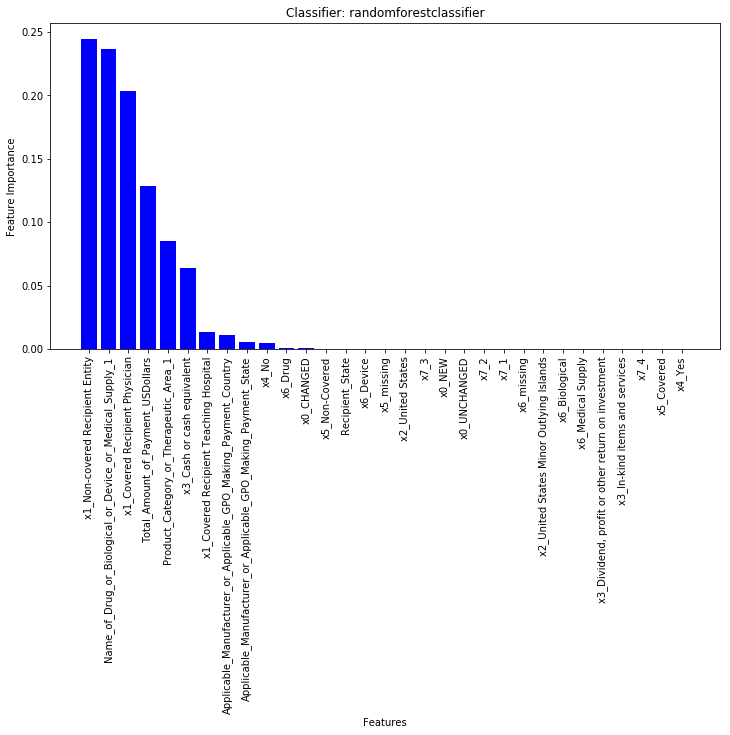

In [37]:
# Random Forest feature importances
features, coef_rf_idx = feature_selection(grid_rf, 'tree', X_train, y_train)

In [38]:
print(features[coef_rf_idx][:10])

['x1_Non-covered Recipient Entity'
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
 'x1_Covered Recipient Physician' 'Total_Amount_of_Payment_USDollars'
 'Product_Category_or_Therapeutic_Area_1' 'x3_Cash or cash equivalent'
 'x1_Covered Recipient Teaching Hospital'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State' 'x4_No']


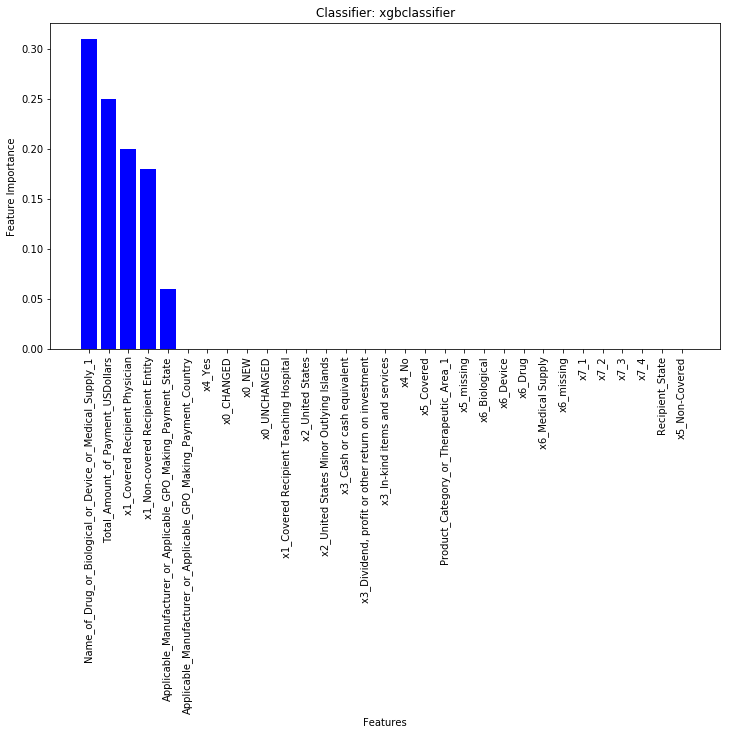

In [39]:
# Gradient Boosting feature importances
_, coef_idx_gb = feature_selection(grid_gb, 'tree', X_train, y_train)

In [46]:
print(features[coef_idx_gb][:5])

['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
 'Total_Amount_of_Payment_USDollars' 'x1_Covered Recipient Physician'
 'x1_Non-covered Recipient Entity'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State']


- Fortunately, the tree-based models attempt to do feature selection automatically.
- We can see there are five important features (four corresponding to the features before OneHotEncoding) identified by Gradient Boosting. These features are also agreed by Random Forest. 
- Since the tree-based models intrinsically do not need one-hot-encoding for categorical features, we keep only these 4 features and refit the model.

In [41]:
imp_features = ['Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
                'Total_Amount_of_Payment_USDollars', 'Covered_Recipient_Type',
                'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State']
X_train_imp = X_train[imp_features]

In [42]:
grid_gb_imp = my_gridsearchCV(X_train_imp, y_train, XGBClassifier(), param_gb)

Best parameter(s): {'xgbclassifier__max_depth': 1}
Best ROC-AUC: 0.995054989186237
Average precision: 0.9589586437144364
Precision: 0.8966124092332387
Recall: 0.955835234256639


- We can see that the model has **improved** after feature selection. So removing irrelevant features makes the model better.
    - Before
        - Best ROC-AUC: 0.994767508942391
        - Average precision: 0.9590947493623678
        - Precision: 0.9005640025748616
        - Recall: 0.955835234256639

# Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model?
An explainable model should be small enough to be easily inspected - say a linear model with few enough coefficients that you can reasonable look at all of them, or a tree with a small number of leafs etc.

In [43]:
param_logr = {'logisticregression__C': np.logspace(-3, 2, 6)}
grid_logr = my_gridsearchCV(X_train_imp, y_train, LogisticRegression(), param_logr)

Best parameter(s): {'logisticregression__C': 0.001}
Best ROC-AUC: 0.995191159246059
Average precision: 0.9508320666480584
Precision: 0.9210287096192105
Recall: 0.9602339422004973


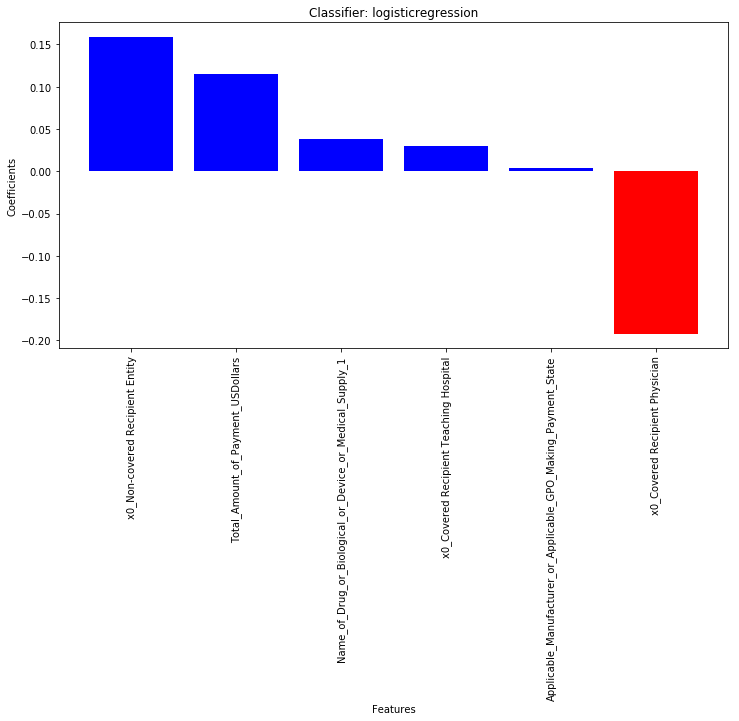

In [44]:
features_imp, coef_idx_logr = feature_selection(grid_logr, 'linear', 
                                                X_train_imp, y_train)

- Notice: 'Covered_Recipient_Type_Covered Recipient Physician' and 'Covered_Recipient_Type_Non-covered Recipient Entity' come from the same categorical feature and strongly contrast to each other. Since the OneHotEncoder generates one more dummy variables statistically, the coeficient magnitudes are reasonable as shown above. Such a result also proves that the feature `Covered_Recipient_Type` is a strong predictor for this classification.
- The rest festures are consistent to the **Gradient Boosting** model.

In [45]:
print(features_imp)

['Total_Amount_of_Payment_USDollars' 'x0_Covered Recipient Physician'
 'x0_Covered Recipient Teaching Hospital'
 'x0_Non-covered Recipient Entity'
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1'
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State']


- The explainable model is a **logistic regression** model with 
    - C = 0.001
    - Four features (six after encoding)
        - 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Total_Amount_of_Payment_USDollars', 'Covered_Recipient_Type', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'
    - Best ROC-AUC: 0.995191159246059
    - Average precision: 0.9508320666480584
    - Precision: 0.9210287096192105
    - Recall: 0.9602339422004973
- Compared to our best model, this model is explainable as it is more compact with close performance to our best **gradient boosting** model
    - max_depth = 1
    - Four features
        - 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Total_Amount_of_Payment_USDollars', 'Covered_Recipient_Type', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State'
    - Best ROC-AUC: 0.995054989186237
    - Average precision: 0.9589586437144364
    - Precision: 0.8966124092332387
    - Recall: 0.955835234256639

- *Side note*. After the feature selection, **logistic regression** gives out a higher F-score than the baseline model does.